In [1]:
import skimage
import os
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_msssim import ssim

sys.path.insert(0, os.path.abspath('..'))
import utils
from incode_experiments import utils as incode_utils
from incode_experiments.models import INR
from incode_experiments import dataio

In [10]:
parser = argparse.ArgumentParser(description='LG_INCODE')

# Shared Parameters
parser.add_argument('--input', type=str, default='../data/DIV2K/denoising/0055.png', help='Input image path')
parser.add_argument('--inr_model', type=str, default='lg_incode', help='[incode, lg_incode, lc_incode]')
parser.add_argument('--lr',type=float, default=1.5e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.1, help='LR scheduler [set it from 0.05 to 0.1]')
parser.add_argument('--niters', type=int, default=401, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')
parser.add_argument('--downsample', type=int, nargs='+', default=(2, 4), help='Partition factors for Local-Global INCODE')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

groups = np.prod(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else 1

if args.inr_model != 'lg_incode':
    args.niters = 1001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [11]:
im = incode_utils.normalize(plt.imread(args.input).astype(np.float32), True)
im = cv2.resize(im, (512, 288), interpolation=cv2.INTER_AREA)
H, W, _ = im.shape

# Create a noisy image using realistic sensor measurement
tau = 4e1 # Photon noise
noise_snr = 2 # Readout noise

im_noisy = incode_utils.measure(im, noise_snr, tau)
im_noisy_gt = incode_utils.normalize(im_noisy, True)[None, ...].astype(np.float32)

## Defining Model

### Model Configureations

In [12]:
### Harmonizer Configurations
MLP_configs={'task': 'denoising',
             'model': 'resnet34',
             'truncated_layer':5,
             'in_channels': 64,             
             'hidden_channels': [32, 16, 12, 12] if args.inr_model == 'lg_incode' else  [32, 16, 12, 4],
             'mlp_bias':0.0005,
             'activation_layer': nn.SiLU,
             'GT': torch.tensor(im_noisy_gt).to(device).permute(0, 3, 1, 2)
            }

### Model Configurations
if 'lc_' in args.inr_model:
    additional_kwargs = {'groups': np.prod(args.downsample), 'hidden_features': 248 * 2 * 4}
elif 'lg_' in args.inr_model:
    additional_kwargs = {'groups': np.prod(args.downsample), 'hidden_features': 80 * 2 * 4, 'global_hidden_features': 82}
else:
    additional_kwargs = {'hidden_features': 256}

model = INR(args.inr_model).run(in_features=2,
                                out_features=3, 
                                hidden_layers=3,
                                first_omega_0=10.0, # Change it from 5 to 20 according to the noise level; higher noise -> lower omega values)
                                hidden_omega_0=30.0,
                                pos_encode_configs={'type': None}, 
                                MLP_configs = MLP_configs,
                                **additional_kwargs
                               ).to(device)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if args.inr_model == 'lg_incode':
    print('Total Params:', count_parameters(model.global_net) + count_parameters(model.net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Global Params:', count_parameters(model.global_net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Local Params:', count_parameters(model.net))
elif 'incode' in args.inr_model:
    print('Total Params', count_parameters(model.net) + count_parameters(model.aux_mlp))

Total Params: 196176
Global Params: 36792
Local Params: 159384


## Training Code

In [14]:
lr = args.lr
optim = torch.optim.Adam(lr=lr, params=[p[1] for p in model.named_parameters() if 'feature_extractor' not in p[0]])

scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR and MSE values
psnr_values = []
ssim_values = []
mse_array = torch.zeros(args.niters, device=device)
mse_array_noisy = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

# Generate coordinate grid
coords = incode_utils.get_coords(H, W, dim=2)[None, ...]

# Convert input image to a tensor and reshape
gt = torch.tensor(im).cuda()

In [15]:
image_dataset = dataio.ImageFileFromArray(im_noisy)
image_dataset = dataio.ImplicitSingle2DWrapper(image_dataset, downsample=tuple(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else None)
image_dataloader = DataLoader(image_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 0 | Total Loss: 0.05859 | PSNR: 12.8759 | SSIM: 0.2169


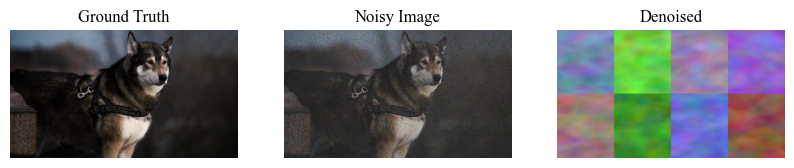

Epoch: 100 | Total Loss: 0.00827 | PSNR: 29.0978 | SSIM: 0.8453


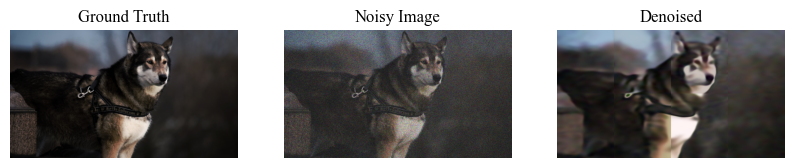

Epoch: 200 | Total Loss: 0.00759 | PSNR: 31.6553 | SSIM: 0.8706


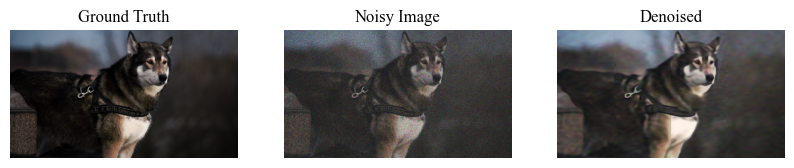

Epoch: 300 | Total Loss: 0.00739 | PSNR: 32.2744 | SSIM: 0.8719


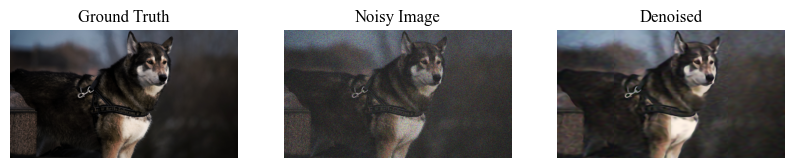

Epoch: 400 | Total Loss: 0.00728 | PSNR: 32.4462 | SSIM: 0.8683


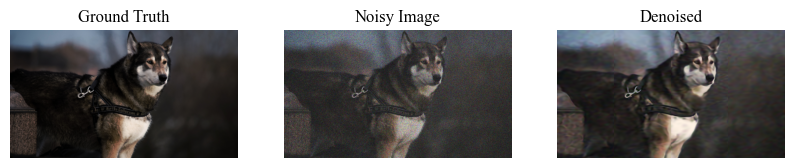

--------------------
Max PSNR: 32.44618225097656
--------------------


In [16]:
for step in tqdm(range(args.niters)):

    for in_dict, gt_dict in image_dataloader:
        b_coords = in_dict['coords_overlap'].cuda()
        model_output, coef = model(b_coords)  

        output_loss = ((model_output - gt_dict['img_overlap'].cuda()) ** 2).mean()
      
        if 'incode' in args.inr_model:
            # Calculate regularization loss for 'incode' model
            all_coeffs = []
            for i in range(0, len(coef[0]), 4):
                all_coeffs.append(coef[0][i:i+4])
            
            reg_loss = args.a_coef * torch.relu(-all_coeffs[0][0]) + \
                       args.b_coef * torch.relu(-all_coeffs[0][1]) + \
                       args.c_coef * torch.relu(-all_coeffs[0][2]) + \
                       args.d_coef * torch.relu(-all_coeffs[0][3])
            
            for coeffs in all_coeffs[1:]:
                reg_loss += args.a_coef * torch.relu(-coeffs[0]) + \
                           args.b_coef * torch.relu(-coeffs[1]) + \
                           args.c_coef * torch.relu(-coeffs[2]) + \
                           args.d_coef * torch.relu(-coeffs[3])
            

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()


    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        scheduler.step()
    
    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        with torch.no_grad():
            model_output, _ = model(in_dict['coords'].cuda())
        
        # Prepare reconstructed image for visualization
        pred_img = dataio.lin2img(model_output, (H, W), image_dataset.gt_slices).cuda().squeeze().permute(1, 2, 0)
        gt_noisy_img = gt_dict['raw_img'].cuda().squeeze()

        # Calculate and log mean squared error (MSE) and PSNR
        with torch.no_grad():
            mse_array_noisy[step] = ((gt_noisy_img - pred_img)**2).mean().item()
            mse_array[step] = ((gt - pred_img)**2).mean().item()
            psnr = -10*torch.log10(mse_array[step])
            psnr_values.append(psnr.item())
            
            ms_ssim_val = ssim(gt.unsqueeze(0).permute(0, 3, 2, 1),
                    pred_img.unsqueeze(0).permute(0, 3, 2, 1),
                    data_range=1, size_average=False)
            ssim_values.append(ms_ssim_val[0].item())

        if psnr == max(psnr_values) or (step == 0):#(mse_array[step] < best_loss) or (step == 0):
            best_loss = mse_array[step]
            best_img = pred_img.detach().cpu().numpy()
            best_img = (best_img - best_img.min()) / (best_img.max() - best_img.min())

        print("Epoch: {} | Total Loss: {:.5f} | PSNR: {:.4f} | SSIM: {:.4f}".format(step, 
                                                                                     mse_array_noisy[step].item(),
                                                                                     psnr.item(),
                                                                                     ms_ssim_val[0].item())) 
        
        # Plot
        im_noisy = (im_noisy - im_noisy.min()) / (im_noisy.max() - im_noisy.min())
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 10))
        axes[0].set_title('Ground Truth')
        axes[0].imshow(im)
        axes[0].axis('off')
        axes[1].set_title('Noisy Image')
        axes[1].imshow(im_noisy)
        axes[1].axis('off')
        axes[2].set_title('Denoised')
        axes[2].imshow(best_img)
        axes[2].axis('off')
        plt.show()

        
# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR:', max(psnr_values))
print('--------------------')

# Convergance Rate

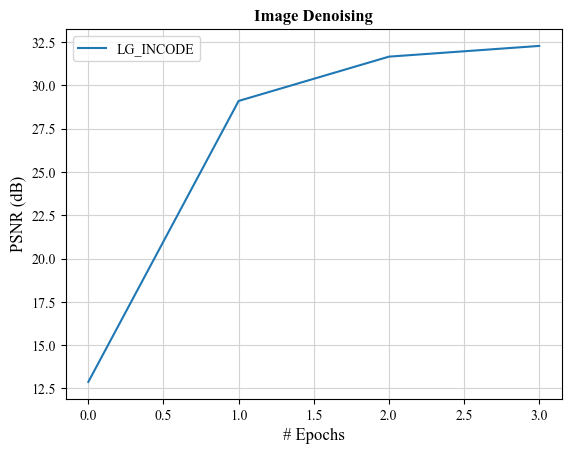

In [17]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(psnr_values[:-1])), psnr_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Denoising', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()